# Import Libraries

In [1]:
import argparse
import math
import os
import os.path as ops
import time

import cv2
import glog as log
import numpy as np
import tensorflow as tf

from easydict import EasyDict as edict
from collections import OrderedDict
import matplotlib.pyplot as plt

In [2]:
# ignore warning for tf 2.0
tf.logging.set_verbosity(tf.logging.ERROR)

In [3]:
print(tf.__version__)

1.13.0-rc2


# Setting Data Set and Weights Path

In [4]:
dataset_dir = 'data/training_data_bdd100k_highway_lane_t5_no_road_edge/'
weights_path = 'model/tusimple_lanenet/tusimple_lanenet_vgg_2018-10-19-13-33-56.ckpt-200000'

# Setting parameters

In [5]:
__C = edict()

cfg = __C

__C.TRAIN = edict()
__C.TRAIN.EPOCHS = 10000
__C.TRAIN.NOOFBATCHES = 10
__C.TRAIN.MOMENTUM = 0.9
__C.TRAIN.LEARNING_RATE = 0.0005
__C.TRAIN.GPU_MEMORY_FRACTION = 0.85
__C.TRAIN.TF_ALLOW_GROWTH = True
__C.TRAIN.BATCH_SIZE = 8
__C.TRAIN.VAL_BATCH_SIZE = 8
__C.TRAIN.IMG_WIDTH = 512
__C.TRAIN.IMG_HEIGHT = 256

# Reading Data Set

In [6]:
class DataSet(object):
    def __init__(self, dataset_info_file):
        self._gt_img_list, self._gt_label_binary_list = self._init_dataset(dataset_info_file)
        self._random_dataset()
        self._next_batch_loop_count = 0

    def _init_dataset(self, dataset_info_file):
        gt_img_list = []
        gt_label_binary_list = []

        assert ops.exists(dataset_info_file), '{:s}　does not exist'.format(dataset_info_file)

        with open(dataset_info_file, 'r') as file:
            for _info in file:
                info_tmp = _info.strip(' ').split()

                gt_img_list.append(info_tmp[0])
                gt_label_binary_list.append(info_tmp[1])

        return gt_img_list, gt_label_binary_list

    def _random_dataset(self):
        assert len(self._gt_img_list) == len(self._gt_label_binary_list)

        random_idx = np.random.permutation(len(self._gt_img_list))
        new_gt_img_list = []
        new_gt_label_binary_list = []

        for index in random_idx:
            new_gt_img_list.append(self._gt_img_list[index])
            new_gt_label_binary_list.append(self._gt_label_binary_list[index])

        self._gt_img_list = new_gt_img_list
        self._gt_label_binary_list = new_gt_label_binary_list

    def next_batch(self, batch_size):
        assert len(self._gt_label_binary_list) == len(self._gt_img_list)

        idx_start = batch_size * self._next_batch_loop_count
        idx_end = batch_size * self._next_batch_loop_count + batch_size

        if idx_start == 0 and idx_end > len(self._gt_label_binary_list):
            raise ValueError('Batch size cannot be larger than the total number of samples', 
                             idx_end, len(self._gt_label_binary_list))

        if idx_end > len(self._gt_label_binary_list):
            self._random_dataset()
            self._next_batch_loop_count = 0
            return self.next_batch(batch_size)
        else:
            gt_img_list = self._gt_img_list[idx_start:idx_end]
            gt_label_binary_list = self._gt_label_binary_list[idx_start:idx_end]

            gt_imgs = []
            gt_labels_binary = []

            for gt_img_path in gt_img_list:
                gt_imgs.append(cv2.imread(gt_img_path, cv2.IMREAD_COLOR))

            for gt_label_path in gt_label_binary_list:
                label_img = cv2.imread(gt_label_path, cv2.IMREAD_COLOR)
                label_binary = np.zeros([label_img.shape[0], label_img.shape[1]], dtype=np.uint8)
                idx = np.where((label_img[:, :, :] != [0, 0, 0]).all(axis=2))
                label_binary[idx] = 1
                gt_labels_binary.append(label_binary)

            self._next_batch_loop_count += 1

        return gt_imgs, gt_labels_binary

In [7]:
# train dataset
train_dataset_file = ops.join(dataset_dir, 'train.txt')
val_dataset_file = ops.join(dataset_dir, 'val.txt')
assert ops.exists(train_dataset_file)
train_dataset = DataSet(train_dataset_file)
val_dataset = DataSet(val_dataset_file)

# CNN Base Function
## cnn_basenet.py

In [8]:
class CNNBaseModel(object):
    def __init__(self):
        pass

    @staticmethod
    def conv2d(inputdata, out_channel, kernel_size, padding='SAME',
               stride=1, w_init=None, b_init=None,
               split=1, use_bias=True, data_format='NHWC', name=None):
        with tf.variable_scope(name):
            in_shape = inputdata.get_shape().as_list()
            channel_axis = 3 if data_format == 'NHWC' else 1
            in_channel = in_shape[channel_axis]
            assert in_channel is not None, "[Conv2D] Input cannot have unknown channel!"
            assert in_channel % split == 0
            assert out_channel % split == 0

            padding = padding.upper()

            if isinstance(kernel_size, list):
                filter_shape = [kernel_size[0], kernel_size[1]] + [in_channel / split, out_channel]
            else:
                filter_shape = [kernel_size, kernel_size] + [in_channel / split, out_channel]

            if isinstance(stride, list):
                strides = [1, stride[0], stride[1], 1] if data_format == 'NHWC' \
                    else [1, 1, stride[0], stride[1]]
            else:
                strides = [1, stride, stride, 1] if data_format == 'NHWC' \
                    else [1, 1, stride, stride]

            if w_init is None:
                w_init = tf.contrib.layers.variance_scaling_initializer()
            if b_init is None:
                b_init = tf.constant_initializer()

            w = tf.get_variable('W', filter_shape, initializer=w_init)
            b = None

            if use_bias:
                b = tf.get_variable('b', [out_channel], initializer=b_init)

            if split == 1:
                conv = tf.nn.conv2d(inputdata, w, strides, padding, data_format=data_format)
            else:
                inputs = tf.split(inputdata, split, channel_axis)
                kernels = tf.split(w, split, 3)
                outputs = [tf.nn.conv2d(i, k, strides, padding, data_format=data_format)
                           for i, k in zip(inputs, kernels)]
                conv = tf.concat(outputs, channel_axis)

            ret = tf.identity(tf.nn.bias_add(conv, b, data_format=data_format) if use_bias else conv, name=name)

        return ret

    @staticmethod
    def relu(inputdata, name=None):
        return tf.nn.relu(features=inputdata, name=name)

    @staticmethod
    def maxpooling(inputdata, kernel_size, stride=None, \
                   padding='VALID', data_format='NHWC', name=None):
        padding = padding.upper()

        if stride is None:
            stride = kernel_size

        if isinstance(kernel_size, list):
            kernel = [1, kernel_size[0], kernel_size[1], 1] if data_format == 'NHWC' \
                else [1, 1, kernel_size[0], kernel_size[1]]
        else:
            kernel = [1, kernel_size, kernel_size, 1] if data_format == 'NHWC' \
                else [1, 1, kernel_size, kernel_size]

        if isinstance(stride, list):
            strides = [1, stride[0], stride[1], 1] if data_format == 'NHWC' \
                else [1, 1, stride[0], stride[1]]
        else:
            strides = [1, stride, stride, 1] if data_format == 'NHWC' \
                else [1, 1, stride, stride]

        return tf.nn.max_pool(value=inputdata, ksize=kernel, strides=strides, \
                              padding=padding, data_format=data_format, name=name)

    @staticmethod
    def layerbn(inputdata, is_training, name):
        return tf.layers.batch_normalization(inputs=inputdata, training=is_training, name=name)

    @staticmethod
    def deconv2d(inputdata, out_channel, kernel_size, padding='SAME',
                 stride=1, w_init=None, b_init=None,
                 use_bias=True, activation=None, data_format='channels_last',
                 trainable=True, name=None):
        with tf.variable_scope(name):
            in_shape = inputdata.get_shape().as_list()
            channel_axis = 3 if data_format == 'channels_last' else 1
            in_channel = in_shape[channel_axis]
            assert in_channel is not None, "[Deconv2D] Input cannot have unknown channel!"

            padding = padding.upper()

            if w_init is None:
                w_init = tf.contrib.layers.variance_scaling_initializer()
            if b_init is None:
                b_init = tf.constant_initializer()

            ret = tf.layers.conv2d_transpose(inputs=inputdata, filters=out_channel,
                                             kernel_size=kernel_size,
                                             strides=stride, padding=padding,
                                             data_format=data_format,
                                             activation=activation, use_bias=use_bias,
                                             kernel_initializer=w_init,
                                             bias_initializer=b_init, trainable=trainable,
                                             name=name)
        return ret

# Defining model using conv2d, Relu and Maxpooling

## fcn_decoder.py

In [9]:
class FCNDecoder(CNNBaseModel):
    def __init__(self, phase):
        super(FCNDecoder, self).__init__()

    def decode(self, input_tensor_dict, decode_layer_list, name):
        ret = dict()

        with tf.variable_scope(name):
            # score stage 1
            input_tensor = input_tensor_dict[decode_layer_list[0]]['data']

            score = self.conv2d(inputdata=input_tensor, out_channel=64,
                                kernel_size=1, use_bias=False, name='score_origin')
            decode_layer_list = decode_layer_list[1:]
            for i in range(len(decode_layer_list)):
                deconv = self.deconv2d(inputdata=score, out_channel=64, kernel_size=4,
                                       stride=2, use_bias=False, name='deconv_{:d}'.format(i + 1))
                input_tensor = input_tensor_dict[decode_layer_list[i]]['data']
                score = self.conv2d(inputdata=input_tensor, out_channel=64,
                                    kernel_size=1, use_bias=False, name='score_{:d}'.format(i + 1))
                fused = tf.add(deconv, score, name='fuse_{:d}'.format(i + 1))
                score = fused

            deconv_final = self.deconv2d(inputdata=score, out_channel=64, kernel_size=16,
                                         stride=8, use_bias=False, name='deconv_final')

            score_final = self.conv2d(inputdata=deconv_final, out_channel=2,
                                      kernel_size=1, use_bias=False, name='score_final')

            ret['logits'] = score_final

        return ret

## vgg_encoder.py
https://github.com/machrisaa/tensorflow-vgg

In [10]:
class VGG16Encoder(CNNBaseModel):
    def __init__(self, phase):
        super(VGG16Encoder, self).__init__()
        self._train_phase = tf.constant('train', dtype=tf.string)
        self._phase = phase
        self._is_training = self._init_phase()

    def _init_phase(self):
        return tf.equal(self._phase, self._train_phase)

    def _conv_stage(self, input_tensor, k_size, out_dims, name,
                    stride=1, pad='SAME'):
        with tf.variable_scope(name):
            conv = self.conv2d(inputdata=input_tensor, out_channel=out_dims,
                               kernel_size=k_size, stride=stride,
                               use_bias=False, padding=pad, name='conv')

            bn = self.layerbn(inputdata=conv, is_training=self._is_training, name='bn')

            relu = self.relu(inputdata=bn, name='relu')

            return relu

    def encode(self, input_tensor, name):
        ret = OrderedDict()

        with tf.variable_scope(name):
            # conv stage 1
            conv_1_1 = self._conv_stage(input_tensor=input_tensor, k_size=3, out_dims=64, name='conv1_1')
            conv_1_2 = self._conv_stage(input_tensor=conv_1_1, k_size=3, out_dims=64, name='conv1_2')
            pool1 = self.maxpooling(inputdata=conv_1_2, kernel_size=2, stride=2, name='pool1')

            # conv stage 2
            conv_2_1 = self._conv_stage(input_tensor=pool1, k_size=3, out_dims=128, name='conv2_1')
            conv_2_2 = self._conv_stage(input_tensor=conv_2_1, k_size=3, out_dims=128, name='conv2_2')
            pool2 = self.maxpooling(inputdata=conv_2_2, kernel_size=2, stride=2, name='pool2')

            # conv stage 3
            conv_3_1 = self._conv_stage(input_tensor=pool2, k_size=3, out_dims=256, name='conv3_1')
            conv_3_2 = self._conv_stage(input_tensor=conv_3_1, k_size=3, out_dims=256, name='conv3_2')
            conv_3_3 = self._conv_stage(input_tensor=conv_3_2, k_size=3, out_dims=256, name='conv3_3')
            pool3 = self.maxpooling(inputdata=conv_3_3, kernel_size=2, stride=2, name='pool3')
            ret['pool3'] = dict()
            ret['pool3']['data'] = pool3
            ret['pool3']['shape'] = pool3.get_shape().as_list()

            # conv stage 4
            conv_4_1 = self._conv_stage(input_tensor=pool3, k_size=3, out_dims=512, name='conv4_1')
            conv_4_2 = self._conv_stage(input_tensor=conv_4_1, k_size=3, out_dims=512, name='conv4_2')
            conv_4_3 = self._conv_stage(input_tensor=conv_4_2, k_size=3, out_dims=512, name='conv4_3')
            pool4 = self.maxpooling(inputdata=conv_4_3, kernel_size=2, stride=2, name='pool4')
            ret['pool4'] = dict()
            ret['pool4']['data'] = pool4
            ret['pool4']['shape'] = pool4.get_shape().as_list()

            # conv stage 5
            conv_5_1 = self._conv_stage(input_tensor=pool4, k_size=3, out_dims=512, name='conv5_1')
            conv_5_2 = self._conv_stage(input_tensor=conv_5_1, k_size=3, out_dims=512, name='conv5_2')
            conv_5_3 = self._conv_stage(input_tensor=conv_5_2, k_size=3, out_dims=512, name='conv5_3')
            pool5 = self.maxpooling(inputdata=conv_5_3, kernel_size=2, stride=2, name='pool5')
            ret['pool5'] = dict()
            ret['pool5']['data'] = pool5
            ret['pool5']['shape'] = pool5.get_shape().as_list()

        return ret

## lanenet_merge_model.py

In [11]:
class LaneNet():
    def __init__(self, phase):
        super(LaneNet, self).__init__()
        self._encoder = VGG16Encoder(phase=phase)
        self._decoder = FCNDecoder(phase=phase)
        return

    def _build_model(self, input_tensor, name):
        with tf.variable_scope(name):
            # first encode
            encode_ret = self._encoder.encode(input_tensor=input_tensor,
                                              name='encode')
            # second decode
            decode_ret = self._decoder.decode(input_tensor_dict=encode_ret,
                                              name='decode',
                                              decode_layer_list=['pool5',
                                                                 'pool4',
                                                                 'pool3'])
            return decode_ret

    def compute_loss(self, input_tensor, binary_label, name):
        with tf.variable_scope(name):
            # Forward propagation to get logits
            inference_ret = self._build_model(input_tensor=input_tensor, name='inference')

            # Calculate the binary partition loss function
            decode_logits = inference_ret['logits']
            binary_label_plain = tf.reshape(binary_label,
                                            shape=[binary_label.get_shape().as_list()[0] *
                                                   binary_label.get_shape().as_list()[1] *
                                                   binary_label.get_shape().as_list()[2]])
            # Add class weights
            unique_labels, unique_id, counts = tf.unique_with_counts(binary_label_plain)
            counts = tf.cast(counts, tf.float32)
            inverse_weights = tf.divide(1.0,
                                        tf.log(tf.add(tf.divide(tf.constant(1.0), counts),
                                                      tf.constant(1.02))))
            inverse_weights = tf.gather(inverse_weights, binary_label)
            binary_segmenatation_loss = tf.losses.sparse_softmax_cross_entropy(labels=binary_label, \
                                                                               logits=decode_logits, \
                                                                               weights=inverse_weights)
            binary_segmenatation_loss = tf.reduce_mean(binary_segmenatation_loss)

            ret = {'loss': binary_segmenatation_loss, 'binary_seg_logits': decode_logits}

            return ret

# Define cost, optimizer and accuracy

In [12]:
CFG = cfg

In [13]:
with tf.device('/gpu:0'):
    input_tensor = tf.placeholder(dtype=tf.float32,
                                  shape=[CFG.TRAIN.BATCH_SIZE, CFG.TRAIN.IMG_HEIGHT,
                                         CFG.TRAIN.IMG_WIDTH, 3],
                                  name='input_tensor')
    binary_label = tf.placeholder(dtype=tf.int64,
                                  shape=[CFG.TRAIN.BATCH_SIZE, CFG.TRAIN.IMG_HEIGHT,
                                         CFG.TRAIN.IMG_WIDTH, 1],
                                         name='binary_label')

    # Create the model
    phase = tf.placeholder(dtype=tf.string, shape=None, name='net_phase')
    net = LaneNet(phase=phase)

    # Define loss
    compute_ret = net.compute_loss(input_tensor=input_tensor, binary_label=binary_label, name='lanenet_model')
    loss = compute_ret['loss']

    # Evaluate model
    out_logits = compute_ret['binary_seg_logits']
    out_logits = tf.nn.softmax(logits=out_logits)
    out_logits_out = tf.argmax(out_logits, axis=-1)
    out = tf.argmax(out_logits, axis=-1)
    out = tf.expand_dims(out, axis=-1)

    idx = tf.where(tf.equal(binary_label, 1))
    pix_cls_ret = tf.gather_nd(out, idx)
    accuracy = tf.count_nonzero(pix_cls_ret)
    accuracy = tf.divide(accuracy, tf.cast(tf.shape(pix_cls_ret)[0], tf.int64))

    # Define optimizer
    global_step = tf.Variable(0, trainable=False)
    learning_rate = tf.train.exponential_decay(CFG.TRAIN.LEARNING_RATE, global_step,
                                               100000, 0.1, staircase=True)
    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    with tf.control_dependencies(update_ops):
        optimizer = tf.train.MomentumOptimizer(learning_rate=learning_rate, \
                                               momentum=CFG.TRAIN.MOMENTUM).minimize(loss=loss,
                                                                                     var_list=tf.trainable_variables(),
                                                                                     global_step=global_step)


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



# Set a session

In [14]:
# Set sess configuration
sess_config = tf.ConfigProto(allow_soft_placement=True)
sess_config.gpu_options.per_process_gpu_memory_fraction = CFG.TRAIN.GPU_MEMORY_FRACTION
sess_config.gpu_options.allow_growth = CFG.TRAIN.TF_ALLOW_GROWTH
sess_config.gpu_options.allocator_type = 'BFC'

sess = tf.Session(config=sess_config)

In [15]:
# Set tf saver
model_save_dir = 'model/tusimple_lanenet'
if not ops.exists(model_save_dir):
    os.makedirs(model_save_dir)

train_start_time = time.strftime('%Y-%m-%d-%H-%M-%S', time.localtime(time.time()))
model_name = 'tusimple_lanenet_{:s}.ckpt'.format(str(train_start_time))
model_save_path = ops.join(model_save_dir, model_name)

saver = tf.train.Saver()

tf.train.write_graph(graph_or_graph_def=sess.graph, logdir='',
                     name='{:s}/lanenet_model.pb'.format(model_save_dir))

'model/tusimple_lanenet/lanenet_model.pb'

In [16]:
# Set tf summary
tboard_save_path = 'tboard/tusimple_lanenet_{:s}'.format(str(train_start_time))
if not ops.exists(tboard_save_path):
    os.makedirs(tboard_save_path)

# train
train_accuracy_scalar = tf.summary.scalar(name='train_accuracy', tensor=accuracy)
train_loss_scalar = tf.summary.scalar(name='train_loss', tensor=loss)
learning_rate_scalar = tf.summary.scalar(name='z_learning_rate', tensor=learning_rate)
train_merged_summary_op = tf.summary.merge([train_accuracy_scalar, train_loss_scalar, learning_rate_scalar])

# val
val_accuracy_scalar = tf.summary.scalar(name='val_accuracy', tensor=accuracy)
val_loss_scalar = tf.summary.scalar(name='val_loss', tensor=loss)
val_merged_summary_op = tf.summary.merge([val_accuracy_scalar, val_loss_scalar])

summary_writer = tf.summary.FileWriter(tboard_save_path)
summary_writer.add_graph(sess.graph)

In [17]:
# Set output image folder
image_save_path = 'data_ret/tusimple_lanenet_{:s}'.format(str(train_start_time))
if not ops.exists(image_save_path):
    os.makedirs(image_save_path)

# Running the session

In [18]:
VGG_MEAN = [103.939, 116.779, 123.68]

train_cost_time_mean = []
val_cost_time_mean = []

history = []

In [19]:
def resize_training_data(gt_imgs, binary_gt_labels):
    gt_imgs = [cv2.resize(tmp,
                          dsize=(CFG.TRAIN.IMG_WIDTH, CFG.TRAIN.IMG_HEIGHT),
                          dst=tmp,
                          interpolation=cv2.INTER_LINEAR)
               for tmp in gt_imgs]
    gt_imgs = [tmp - VGG_MEAN for tmp in gt_imgs]

    binary_gt_labels = [cv2.resize(tmp,
                                   dsize=(CFG.TRAIN.IMG_WIDTH, CFG.TRAIN.IMG_HEIGHT),
                                   dst=tmp,
                                   interpolation=cv2.INTER_NEAREST)
                        for tmp in binary_gt_labels]
    binary_gt_labels = [np.expand_dims(tmp, axis=-1) for tmp in binary_gt_labels]
    
    return gt_imgs, binary_gt_labels

In [20]:
with sess.as_default():
    # sess init or restore
    if weights_path is None:
        log.info('Training from scratch')
        init = tf.global_variables_initializer()
        sess.run(init)

        # read vgg model
        pretrained_weights = np.load('./data/vgg16.npy', encoding='latin1').item()
        for vv in tf.trainable_variables():
            weights_key = vv.name.split('/')[-3]
            try:
                weights = pretrained_weights[weights_key][0]
                _op = tf.assign(vv, weights)
                sess.run(_op)
            except Exception as e:
                continue
    else:
        log.info('Restore model from last model checkpoint {:s}'.format(weights_path))
        # restore weights
        saver.restore(sess=sess, save_path=weights_path)

    # epoch loop
    for epoch in range(CFG.TRAIN.EPOCHS):
        
        # ------------------------------ training part ------------------------------
        # Use training data for optimization
        for _ in range(CFG.TRAIN.NOOFBATCHES):
            with tf.device('/cpu:0'):
                gt_imgs, binary_gt_labels = train_dataset.next_batch(CFG.TRAIN.BATCH_SIZE)
                gt_imgs, binary_gt_labels = resize_training_data(gt_imgs, binary_gt_labels)

            sess.run(optimizer, feed_dict={input_tensor:gt_imgs, 
                                           binary_label:binary_gt_labels, 
                                           phase:'train'})

        # run loss and accuracy after optimizing
        t_start = time.time()
        with tf.device('/cpu:0'):
            gt_imgs, binary_gt_labels = train_dataset.next_batch(CFG.TRAIN.BATCH_SIZE)
            gt_imgs, binary_gt_labels = resize_training_data(gt_imgs, binary_gt_labels)

        train_loss, train_accuracy, train_img, train_summary = \
            sess.run([loss, accuracy, out_logits_out, train_merged_summary_op],
                     feed_dict={input_tensor: gt_imgs,
                                binary_label: binary_gt_labels,
                                phase: 'train'})

        # time
        cost_time = time.time() - t_start
        train_cost_time_mean.append(cost_time)
        
        # summary
        summary_writer.add_summary(summary=train_summary, global_step=epoch)

        # ------------------------------ validation part ------------------------------
        # run loss and accuracy after optimizing
        t_start = time.time()
        with tf.device('/cpu:0'):
            gt_imgs, binary_gt_labels = val_dataset.next_batch(CFG.TRAIN.VAL_BATCH_SIZE)
            gt_imgs, binary_gt_labels = resize_training_data(gt_imgs, binary_gt_labels)

        val_loss, val_accuracy, val_img, val_summary = \
            sess.run([loss, accuracy, out_logits_out, val_merged_summary_op],
                     feed_dict={input_tensor: gt_imgs,
                                binary_label: binary_gt_labels,
                                phase: 'test'})

        # time
        cost_time = time.time() - t_start
        val_cost_time_mean.append(cost_time)
        
        # summary
        summary_writer.add_summary(summary=val_summary, global_step=epoch)        
        
        # ------------------------------ logging part ------------------------------
        # history
        if epoch*CFG.TRAIN.NOOFBATCHES > 10:
            history.append([train_loss, train_accuracy, val_loss, val_accuracy])

        # progress
        if epoch*CFG.TRAIN.NOOFBATCHES % 100 == 0:
            print('Epoch:{:d} loss={:3f} acc={:3f} ctime={:3f}s vloss={:3f} vacc={:3f} vctime={:3f}s '.
                  format(epoch, train_loss, train_accuracy, np.mean(train_cost_time_mean), \
                         val_loss, val_accuracy, np.mean(val_cost_time_mean)))
            train_cost_time_mean.clear()
            val_cost_time_mean.clear()

        # output image
        if epoch*CFG.TRAIN.NOOFBATCHES % 100 == 0:
            binary_seg_image_3ch = np.array([[[0]*3]*__C.TRAIN.IMG_WIDTH]*__C.TRAIN.IMG_HEIGHT, np.float64)
            binary_seg_image_3ch[:, :, 0] = 0
            binary_seg_image_3ch[:, :, 1] = 0
            binary_seg_image_3ch[:, :, 2] = val_img[0][:, :]*255
            image = gt_imgs[0] + VGG_MEAN
            image_field2 = cv2.addWeighted(image, 1.0, binary_seg_image_3ch, 1.0, 0.0)
            path = image_save_path + '/image_{:d}.png'.format(epoch)
            cv2.imwrite(path, image_field2)

        # store model
        if epoch*CFG.TRAIN.NOOFBATCHES % 2000 == 0:
            saver.save(sess=sess, save_path=model_save_path, global_step=epoch)

# store model
saver.save(sess=sess, save_path=model_save_path, global_step=epoch)

sess.close()

I0409 12:33:08.078207 10528 <ipython-input-20-8c0a894cc226>:19] Restore model from last model checkpoint model/tusimple_lanenet/tusimple_lanenet_vgg_2018-10-19-13-33-56.ckpt-200000


Epoch:0 loss=52.353939 acc=0.157874 ctime=0.556259s vloss=51.792194 vacc=0.152702 vctime=0.559561s 
Epoch:10 loss=13.856318 acc=0.444694 ctime=0.407747s vloss=19.922239 vacc=0.235381 vctime=0.399407s 
Epoch:20 loss=11.436406 acc=0.327126 ctime=0.404049s vloss=17.726669 vacc=0.318499 vctime=0.403077s 
Epoch:30 loss=6.538970 acc=0.351959 ctime=0.404093s vloss=7.073625 vacc=0.422904 vctime=0.403747s 
Epoch:40 loss=6.312098 acc=0.393571 ctime=0.407077s vloss=6.105299 vacc=0.396819 vctime=0.406507s 
Epoch:50 loss=7.124419 acc=0.328817 ctime=0.402044s vloss=5.148962 vacc=0.396441 vctime=0.403184s 
Epoch:60 loss=4.612813 acc=0.396446 ctime=0.406012s vloss=6.431235 vacc=0.353461 vctime=0.403892s 
Epoch:70 loss=4.880415 acc=0.329416 ctime=0.408287s vloss=6.255629 vacc=0.352017 vctime=0.411362s 
Epoch:80 loss=4.881656 acc=0.244669 ctime=0.404501s vloss=4.378593 vacc=0.382580 vctime=0.398306s 
Epoch:90 loss=4.517335 acc=0.341267 ctime=0.388030s vloss=3.979688 vacc=0.374088 vctime=0.395155s 
Epoch

Epoch:820 loss=2.108464 acc=0.363194 ctime=0.387438s vloss=2.563984 vacc=0.385240 vctime=0.394986s 
Epoch:830 loss=3.188497 acc=0.217135 ctime=0.389817s vloss=2.220403 vacc=0.510557 vctime=0.392513s 
Epoch:840 loss=1.931607 acc=0.438028 ctime=0.399852s vloss=2.225350 vacc=0.341685 vctime=0.399512s 
Epoch:850 loss=2.626357 acc=0.324598 ctime=0.400857s vloss=3.020241 vacc=0.316869 vctime=0.395329s 
Epoch:860 loss=1.843251 acc=0.410593 ctime=0.387440s vloss=2.510104 vacc=0.363100 vctime=0.395400s 
Epoch:870 loss=2.310988 acc=0.428378 ctime=0.386029s vloss=2.464087 vacc=0.408035 vctime=0.384613s 
Epoch:880 loss=2.179033 acc=0.405888 ctime=0.393011s vloss=2.911670 vacc=0.197325 vctime=0.394229s 
Epoch:890 loss=2.441437 acc=0.409552 ctime=0.380104s vloss=2.441612 vacc=0.415376 vctime=0.386842s 
Epoch:900 loss=2.460704 acc=0.325185 ctime=0.386927s vloss=1.904731 vacc=0.352045 vctime=0.388745s 
Epoch:910 loss=2.550608 acc=0.303878 ctime=0.382919s vloss=2.019880 vacc=0.405205 vctime=0.389818s 


Epoch:1640 loss=2.079650 acc=0.335792 ctime=0.381180s vloss=1.953993 vacc=0.401078 vctime=0.390880s 
Epoch:1650 loss=2.074473 acc=0.356556 ctime=0.391047s vloss=2.225921 vacc=0.408888 vctime=0.386791s 
Epoch:1660 loss=2.201924 acc=0.400438 ctime=0.383350s vloss=2.033742 vacc=0.380125 vctime=0.386171s 
Epoch:1670 loss=1.963137 acc=0.414250 ctime=0.388740s vloss=2.457279 vacc=0.355501 vctime=0.389305s 
Epoch:1680 loss=1.744643 acc=0.453220 ctime=0.388193s vloss=2.051370 vacc=0.392211 vctime=0.389466s 
Epoch:1690 loss=2.209556 acc=0.338035 ctime=0.384940s vloss=2.143734 vacc=0.374656 vctime=0.386673s 
Epoch:1700 loss=2.255573 acc=0.386555 ctime=0.384822s vloss=2.597809 vacc=0.387772 vctime=0.380007s 
Epoch:1710 loss=1.825025 acc=0.429472 ctime=0.388703s vloss=1.749532 vacc=0.369731 vctime=0.388196s 
Epoch:1720 loss=2.229154 acc=0.383400 ctime=0.392526s vloss=1.771167 vacc=0.501250 vctime=0.387036s 
Epoch:1730 loss=2.081134 acc=0.417594 ctime=0.388426s vloss=2.177987 vacc=0.459776 vctime=0

Epoch:2460 loss=1.646062 acc=0.404077 ctime=0.387049s vloss=2.557160 vacc=0.308000 vctime=0.383131s 
Epoch:2470 loss=2.106588 acc=0.366885 ctime=0.384545s vloss=2.128340 vacc=0.345539 vctime=0.386626s 
Epoch:2480 loss=1.939228 acc=0.348441 ctime=0.382228s vloss=2.136904 vacc=0.423593 vctime=0.382466s 
Epoch:2490 loss=2.034064 acc=0.394010 ctime=0.384016s vloss=2.080358 vacc=0.384072 vctime=0.386367s 
Epoch:2500 loss=1.598627 acc=0.420065 ctime=0.382693s vloss=1.783812 vacc=0.435526 vctime=0.382153s 
Epoch:2510 loss=1.632558 acc=0.460338 ctime=0.387946s vloss=2.597906 vacc=0.372953 vctime=0.390070s 
Epoch:2520 loss=1.666247 acc=0.520948 ctime=0.384828s vloss=2.242762 vacc=0.443773 vctime=0.393222s 
Epoch:2530 loss=1.729524 acc=0.459784 ctime=0.385407s vloss=2.157696 vacc=0.402337 vctime=0.389514s 
Epoch:2540 loss=2.609885 acc=0.349015 ctime=0.383193s vloss=1.935257 vacc=0.438213 vctime=0.389006s 
Epoch:2550 loss=1.854521 acc=0.416590 ctime=0.379418s vloss=1.653060 vacc=0.393904 vctime=0

Epoch:3280 loss=1.736258 acc=0.541221 ctime=0.394018s vloss=1.488983 vacc=0.451738 vctime=0.390257s 
Epoch:3290 loss=1.990276 acc=0.415688 ctime=0.385733s vloss=2.267578 vacc=0.360652 vctime=0.391460s 
Epoch:3300 loss=2.184190 acc=0.268387 ctime=0.386559s vloss=2.180163 vacc=0.404023 vctime=0.393081s 
Epoch:3310 loss=1.758147 acc=0.474187 ctime=0.404473s vloss=1.884537 vacc=0.355074 vctime=0.409174s 
Epoch:3320 loss=1.460238 acc=0.386515 ctime=0.398542s vloss=1.869323 vacc=0.487454 vctime=0.395024s 
Epoch:3330 loss=1.727686 acc=0.487315 ctime=0.382815s vloss=1.950855 vacc=0.392341 vctime=0.382597s 
Epoch:3340 loss=1.955718 acc=0.382334 ctime=0.394013s vloss=2.190830 vacc=0.384694 vctime=0.397220s 
Epoch:3350 loss=2.077379 acc=0.428248 ctime=0.390807s vloss=2.136422 vacc=0.423375 vctime=0.388650s 
Epoch:3360 loss=2.094820 acc=0.336323 ctime=0.386993s vloss=2.231562 vacc=0.458104 vctime=0.389529s 
Epoch:3370 loss=1.575206 acc=0.364815 ctime=0.398176s vloss=1.916341 vacc=0.405027 vctime=0

Epoch:4100 loss=1.546055 acc=0.476772 ctime=0.390260s vloss=1.667550 vacc=0.468241 vctime=0.391197s 
Epoch:4110 loss=2.035497 acc=0.367396 ctime=0.385778s vloss=1.696592 vacc=0.418001 vctime=0.389817s 
Epoch:4120 loss=1.537890 acc=0.493084 ctime=0.392227s vloss=2.151015 vacc=0.307082 vctime=0.389538s 
Epoch:4130 loss=1.576942 acc=0.482820 ctime=0.385759s vloss=1.856216 vacc=0.431773 vctime=0.384419s 
Epoch:4140 loss=2.066008 acc=0.422432 ctime=0.391898s vloss=1.969940 vacc=0.465264 vctime=0.390926s 
Epoch:4150 loss=2.079401 acc=0.432039 ctime=0.389720s vloss=1.859927 vacc=0.458054 vctime=0.388983s 
Epoch:4160 loss=2.168623 acc=0.461538 ctime=0.390307s vloss=1.659245 vacc=0.394111 vctime=0.392604s 
Epoch:4170 loss=1.484955 acc=0.484557 ctime=0.408598s vloss=1.694584 vacc=0.358793 vctime=0.401543s 
Epoch:4180 loss=2.278583 acc=0.348096 ctime=0.377039s vloss=1.721239 vacc=0.424840 vctime=0.380232s 
Epoch:4190 loss=1.868205 acc=0.473004 ctime=0.372000s vloss=2.100575 vacc=0.326962 vctime=0

Epoch:4920 loss=1.729854 acc=0.433870 ctime=0.396108s vloss=1.839242 vacc=0.496910 vctime=0.392137s 
Epoch:4930 loss=1.734861 acc=0.402404 ctime=0.385768s vloss=1.948702 vacc=0.500000 vctime=0.381298s 
Epoch:4940 loss=2.222410 acc=0.463779 ctime=0.381996s vloss=1.783103 vacc=0.511982 vctime=0.382419s 
Epoch:4950 loss=1.684415 acc=0.469338 ctime=0.383581s vloss=1.750942 vacc=0.529732 vctime=0.381996s 
Epoch:4960 loss=1.974806 acc=0.323462 ctime=0.383536s vloss=1.563632 vacc=0.521529 vctime=0.379357s 
Epoch:4970 loss=1.880533 acc=0.496739 ctime=0.382552s vloss=1.887394 vacc=0.467460 vctime=0.386342s 
Epoch:4980 loss=1.490616 acc=0.596495 ctime=0.385075s vloss=1.563817 vacc=0.388205 vctime=0.381651s 
Epoch:4990 loss=1.880206 acc=0.360124 ctime=0.381434s vloss=1.511783 vacc=0.466111 vctime=0.386307s 
Epoch:5000 loss=1.429661 acc=0.498590 ctime=0.393298s vloss=1.840150 vacc=0.320071 vctime=0.396267s 
Epoch:5010 loss=2.107850 acc=0.403255 ctime=0.393598s vloss=2.598293 vacc=0.404993 vctime=0

Epoch:5740 loss=1.866608 acc=0.532829 ctime=0.403930s vloss=2.383933 vacc=0.397638 vctime=0.401591s 
Epoch:5750 loss=1.582148 acc=0.471930 ctime=0.393553s vloss=1.682877 vacc=0.376255 vctime=0.397137s 
Epoch:5760 loss=1.772131 acc=0.369232 ctime=0.393471s vloss=1.770710 vacc=0.406605 vctime=0.402188s 
Epoch:5770 loss=1.721289 acc=0.419122 ctime=0.389190s vloss=2.322526 vacc=0.364978 vctime=0.392742s 
Epoch:5780 loss=1.977583 acc=0.419489 ctime=0.392232s vloss=1.627613 vacc=0.365341 vctime=0.392631s 
Epoch:5790 loss=1.931976 acc=0.491666 ctime=0.386541s vloss=1.786189 vacc=0.422616 vctime=0.393291s 
Epoch:5800 loss=2.073478 acc=0.388961 ctime=0.389450s vloss=2.003319 vacc=0.424329 vctime=0.397078s 
Epoch:5810 loss=1.751657 acc=0.545156 ctime=0.394891s vloss=1.896307 vacc=0.449103 vctime=0.394837s 
Epoch:5820 loss=1.608245 acc=0.459465 ctime=0.395504s vloss=1.711889 vacc=0.429330 vctime=0.388941s 
Epoch:5830 loss=1.657775 acc=0.477983 ctime=0.387071s vloss=1.520603 vacc=0.474675 vctime=0

Epoch:6560 loss=1.735613 acc=0.445615 ctime=0.375621s vloss=1.756008 vacc=0.454250 vctime=0.378202s 
Epoch:6570 loss=2.250257 acc=0.402632 ctime=0.377507s vloss=1.340787 vacc=0.497106 vctime=0.375635s 
Epoch:6580 loss=1.649729 acc=0.442687 ctime=0.379096s vloss=2.374994 vacc=0.454933 vctime=0.381403s 
Epoch:6590 loss=1.543133 acc=0.489248 ctime=0.380434s vloss=2.430461 vacc=0.351990 vctime=0.375397s 
Epoch:6600 loss=1.889223 acc=0.481142 ctime=0.403673s vloss=2.137043 vacc=0.443437 vctime=0.403190s 
Epoch:6610 loss=1.607982 acc=0.458583 ctime=0.404689s vloss=1.670115 vacc=0.503693 vctime=0.402435s 
Epoch:6620 loss=1.787265 acc=0.432265 ctime=0.383526s vloss=1.776335 vacc=0.400681 vctime=0.379820s 
Epoch:6630 loss=2.022685 acc=0.488148 ctime=0.384954s vloss=2.056399 vacc=0.351916 vctime=0.387593s 
Epoch:6640 loss=1.786997 acc=0.467009 ctime=0.380702s vloss=1.879283 vacc=0.452843 vctime=0.383245s 
Epoch:6650 loss=1.690174 acc=0.456434 ctime=0.386467s vloss=1.438383 vacc=0.489400 vctime=0

Epoch:7380 loss=1.931721 acc=0.423932 ctime=0.390977s vloss=1.828315 vacc=0.398506 vctime=0.389107s 
Epoch:7390 loss=1.616825 acc=0.568886 ctime=0.378933s vloss=1.814424 vacc=0.463642 vctime=0.383087s 
Epoch:7400 loss=2.072587 acc=0.388579 ctime=0.373810s vloss=1.822424 vacc=0.537295 vctime=0.376611s 
Epoch:7410 loss=1.611360 acc=0.572126 ctime=0.373137s vloss=2.647785 vacc=0.355263 vctime=0.376498s 
Epoch:7420 loss=1.748617 acc=0.428786 ctime=0.374832s vloss=1.894903 vacc=0.466316 vctime=0.376125s 
Epoch:7430 loss=2.072342 acc=0.469085 ctime=0.377339s vloss=2.207424 vacc=0.392872 vctime=0.380268s 
Epoch:7440 loss=1.636538 acc=0.553723 ctime=0.377665s vloss=1.701320 vacc=0.444280 vctime=0.378286s 
Epoch:7450 loss=1.596401 acc=0.526706 ctime=0.381426s vloss=1.754898 vacc=0.397493 vctime=0.385233s 
Epoch:7460 loss=1.542796 acc=0.505302 ctime=0.380487s vloss=1.923107 vacc=0.395122 vctime=0.380616s 
Epoch:7470 loss=1.481664 acc=0.558590 ctime=0.379974s vloss=2.826845 vacc=0.357229 vctime=0

Epoch:8200 loss=1.449529 acc=0.531324 ctime=0.371038s vloss=1.602641 vacc=0.406015 vctime=0.372676s 
Epoch:8210 loss=1.656913 acc=0.476288 ctime=0.371281s vloss=1.619331 vacc=0.471115 vctime=0.370248s 
Epoch:8220 loss=1.856391 acc=0.434264 ctime=0.369743s vloss=2.065370 vacc=0.421194 vctime=0.372678s 
Epoch:8230 loss=1.619889 acc=0.418019 ctime=0.371782s vloss=1.786398 vacc=0.452379 vctime=0.368128s 
Epoch:8240 loss=2.075898 acc=0.486490 ctime=0.371798s vloss=1.550585 vacc=0.476589 vctime=0.371376s 
Epoch:8250 loss=1.469801 acc=0.472601 ctime=0.367376s vloss=1.600593 vacc=0.548412 vctime=0.372750s 
Epoch:8260 loss=2.042655 acc=0.395145 ctime=0.372205s vloss=1.908871 vacc=0.456412 vctime=0.367472s 
Epoch:8270 loss=1.935592 acc=0.351627 ctime=0.370203s vloss=1.379247 vacc=0.558525 vctime=0.370293s 
Epoch:8280 loss=1.820804 acc=0.378313 ctime=0.371754s vloss=1.503607 vacc=0.557707 vctime=0.372697s 
Epoch:8290 loss=1.654106 acc=0.464271 ctime=0.370147s vloss=2.043373 vacc=0.414592 vctime=0

Epoch:9020 loss=1.891996 acc=0.525016 ctime=0.369148s vloss=1.494541 vacc=0.514194 vctime=0.369007s 
Epoch:9030 loss=1.711854 acc=0.436053 ctime=0.369638s vloss=1.549834 vacc=0.506267 vctime=0.370341s 
Epoch:9040 loss=1.402959 acc=0.440748 ctime=0.373525s vloss=1.787271 vacc=0.459223 vctime=0.369445s 
Epoch:9050 loss=1.498998 acc=0.411254 ctime=0.369079s vloss=1.694390 vacc=0.538126 vctime=0.371380s 
Epoch:9060 loss=1.622239 acc=0.516486 ctime=0.368950s vloss=1.682840 vacc=0.410758 vctime=0.369992s 
Epoch:9070 loss=2.194841 acc=0.326837 ctime=0.369116s vloss=2.235611 vacc=0.452455 vctime=0.368125s 
Epoch:9080 loss=1.869221 acc=0.484796 ctime=0.374759s vloss=1.631433 vacc=0.481264 vctime=0.372290s 
Epoch:9090 loss=1.556145 acc=0.525987 ctime=0.371840s vloss=1.864520 vacc=0.417294 vctime=0.372439s 
Epoch:9100 loss=1.437256 acc=0.478760 ctime=0.373806s vloss=1.660072 vacc=0.427823 vctime=0.371613s 
Epoch:9110 loss=1.812433 acc=0.458733 ctime=0.370011s vloss=1.748886 vacc=0.471624 vctime=0

Epoch:9840 loss=2.040724 acc=0.526387 ctime=0.371116s vloss=1.863718 vacc=0.496489 vctime=0.369251s 
Epoch:9850 loss=1.272907 acc=0.535172 ctime=0.373745s vloss=1.743745 vacc=0.469497 vctime=0.371172s 
Epoch:9860 loss=1.434665 acc=0.556955 ctime=0.373719s vloss=2.089481 vacc=0.401074 vctime=0.371426s 
Epoch:9870 loss=1.626437 acc=0.465936 ctime=0.372154s vloss=1.614897 vacc=0.457825 vctime=0.373009s 
Epoch:9880 loss=2.002450 acc=0.432800 ctime=0.373282s vloss=2.014553 vacc=0.321274 vctime=0.369230s 
Epoch:9890 loss=1.473748 acc=0.560642 ctime=0.367826s vloss=1.638006 vacc=0.456340 vctime=0.372863s 
Epoch:9900 loss=1.649546 acc=0.459289 ctime=0.370716s vloss=1.663254 vacc=0.422330 vctime=0.365771s 
Epoch:9910 loss=1.281029 acc=0.543226 ctime=0.368396s vloss=1.483110 vacc=0.528677 vctime=0.365816s 
Epoch:9920 loss=1.677839 acc=0.421805 ctime=0.375735s vloss=1.823709 vacc=0.422061 vctime=0.375841s 
Epoch:9930 loss=1.884132 acc=0.500275 ctime=0.380278s vloss=2.008871 vacc=0.424946 vctime=0

In [21]:
history = np.array(history)

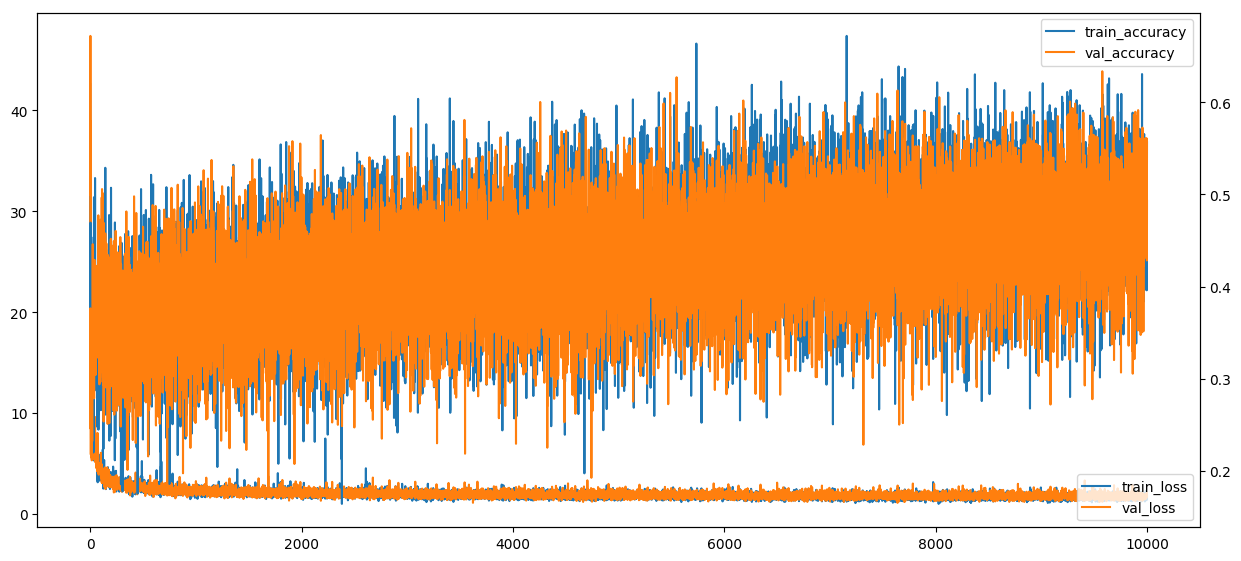

In [22]:
cmap = plt.get_cmap("tab10")

fig = plt.figure(figsize=(15,15),dpi=100)
ax1 = fig.add_subplot(2,1,1, facecolor='w')
ax1.plot(np.arange(1, history.shape[0] + 1), history[:, 0], label='train_loss')
ax1.plot(np.arange(1, history.shape[0] + 1), history[:, 2], label='val_loss', color=cmap(1))
ax2 = ax1.twinx()
ax2.plot(np.arange(1, history.shape[0] + 1), history[:, 1], label='train_accuracy')
ax2.plot(np.arange(1, history.shape[0] + 1), history[:, 3], label='val_accuracy', color=cmap(1))
ax1.legend(loc="lower right")
ax2.legend(loc="upper right")

plt.show()